# EX6 Clustering

Points
- Q1 2P
- Q2 6P
- Q3 2P

In [1]:
# matplotlib日本語化用モジュールをインストール
!pip install japanize-matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.1 MB 5.7 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120341 sha256=7b8bedbe22fb4c1925bdcd27209643b050109c722db4786a29d45310a68567ab
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [2]:
# モジュールのインポート
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import japanize_matplotlib

## Hierarchical clustering
Let us consider performing hierarchical clustering of prefectures based on the similarity (distance) between prefectures using their weather data.

The weather data consists of annual average temperature (°C) and annual precipitation (mm) in 2018 for each prefecture, which was obtained from the following government statistics portal, e-Stat.

[都道府県・市区町村のすがた（社会・人口統計体系）](https://www.e-stat.go.jp/regional-statistics/ssdsview/prefectures)

In [3]:
# Colaboratoryでは以下を実行して必要なファイルをダウンロード
!wget https://raw.githubusercontent.com/UTDataMining/2022A/master/ex6/weather.xlsx

--2022-11-16 10:02:31--  https://raw.githubusercontent.com/UTDataMining/2022A/master/ex6/weather.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11427 (11K) [application/octet-stream]
Saving to: ‘weather.xlsx’

weather.xlsx        100%[===================>]  11.16K  --.-KB/s    in 0.001s  

2022-11-16 10:02:32 (21.1 MB/s) - ‘weather.xlsx’ saved [11427/11427]



In [4]:
# 気象データファイルの読み込み（年平均気温: Temp、年間降水量: Rain）
weather_df = pd.read_excel('weather.xlsx', header=4, usecols=[0,2,3],  skiprows=[5], skipfooter=4, names=['Pref','Temp','Rain']) 
weather_df

,Pref,Temp,Rain
0,北海道,9.5,1282.0
1,青森県,11.0,1553.0
2,岩手県,11.0,1322.0
3,宮城県,13.6,1082.0
4,秋田県,12.3,2016.5
5,山形県,12.6,1124.0
6,福島県,14.2,828.0
7,茨城県,15.3,1282.5
8,栃木県,15.2,1257.0
9,群馬県,16.1,1046.5


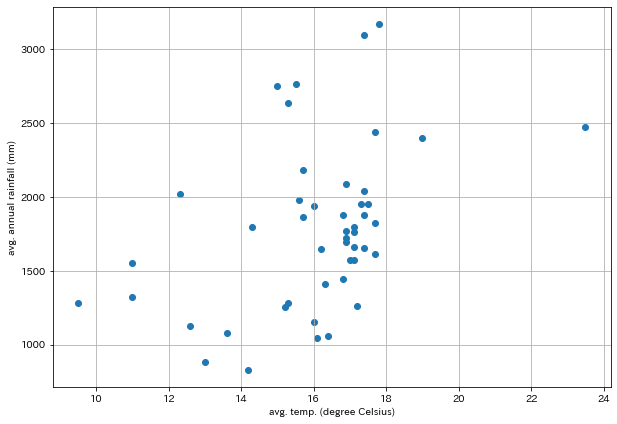

In [5]:
# 散布図
plt.figure(figsize=(10,7))
plt.scatter(weather_df['Temp'], weather_df['Rain'])
plt.xlabel('avg. temp. (degree Celsius)')
plt.ylabel('avg. annual rainfall (mm)')
plt.grid(True);

For hierarchical clustering, we use hierarchical clustering module (`scipy.cluster.hierarchy`) in SciPy.

The `linkage` function takes a matrix consisting of feature vectors as its input, performs hierarchical clustering with the distance measure specified by the `metric` argument and the distance calculation method specified by the `method` argument, and returns the clustering process between the feature vectors as a matrix.

- `metric` argument: cosine, euclidean, jaccard, hamming, correlation, mahalanobis, etc.
  - [scipy.spatial.distance.pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist)

- `method` argument: single, complete, average, ward, etc.
  - [scipy.cluster.hierarchy.linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html)


In the following, a two-dimensional array of standardised prefectural weather data is specified as input to the `linkage` function.

The `dendrogram` function takes output by the `linkage` function, which represents the clustering process, as input and visualises a dendrogram. The `labels` argument specifies a list of labels to be assigned to each data point.


In [6]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

In [8]:
X = weather_df[['Temp', 'Rain']].values # データフレーム から配列に変換
X = (X-X.mean(axis=0))/X.std(axis=0) # 標準化

prefs = weather_df['Pref'].values # 都道府県名ラベル

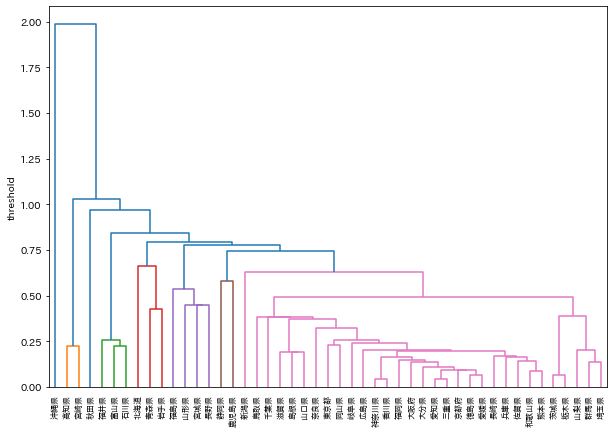

In [9]:
# 距離計算方法single
clusters = linkage(X, metric = 'euclidean', method = 'single')

plt.figure(figsize=(10,7))
dendrogram(clusters, labels=prefs,  color_threshold=0.7)
plt.ylabel('threshold');

 Change the distance calculation method to `complete` or `average` and perform hierarchical clustering. And observe how the clustering results change.
 
By changing `color_thereshold` in `dendrogram`, you can obtain different numbers of clusters.


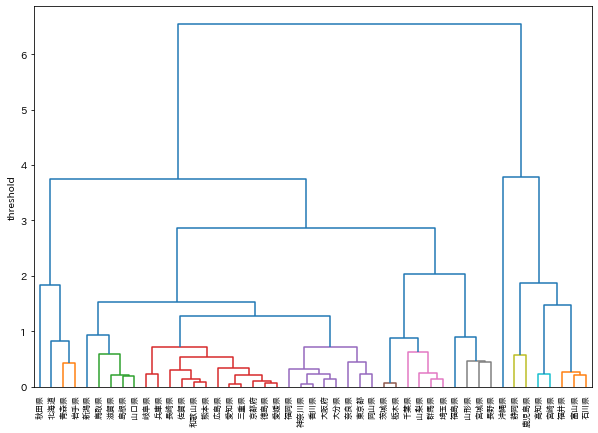

In [10]:
# 距離計算方法complete
clusters = linkage(X, metric = 'euclidean', method = 'complete')

plt.figure(figsize=(10,7))
dendrogram(clusters, labels=prefs,  color_threshold=0.8)
plt.ylabel('threshold');

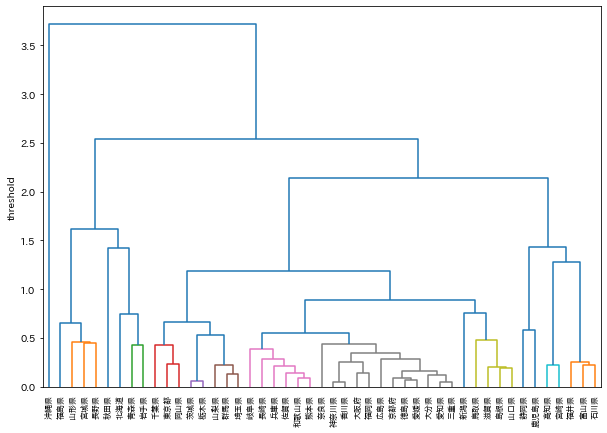

In [11]:
# 距離計算方法average
clusters = linkage(X, metric = 'euclidean', method = 'average')

plt.figure(figsize=(10,7))
dendrogram(clusters, labels=prefs,  color_threshold=0.5)
plt.ylabel('threshold');

### 参考
The `linkage` function also takes a matrix of distances between feature vectors as input.

[scipy.spatial.distance.pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html)

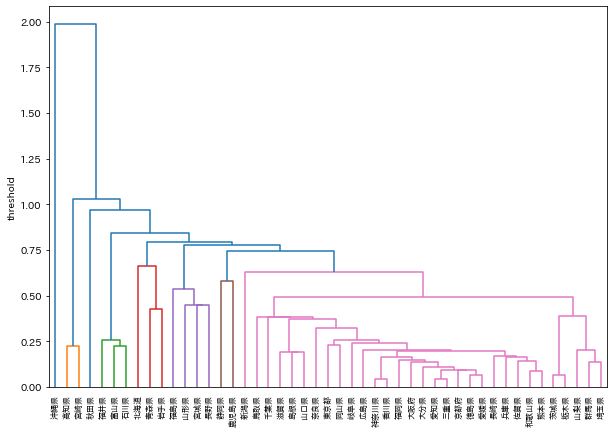

In [12]:
from scipy.spatial.distance import pdist

# 階層化クラスタリング
# 距離尺度を'euclidean'、距離計算は'single'
clusters = linkage(pdist(X, metric='euclidean'), method='single')

# デンドログラム
plt.figure(figsize=(10,7))
dendrogram(clusters, labels=prefs,  color_threshold=0.7)
plt.ylabel('threshold');

In [13]:
from scipy.spatial.distance import squareform

# 距離行列
dist_matrix = pd.DataFrame(squareform(pdist(X, metric='euclidean')), columns=prefs, index=prefs)
dist_matrix

,北海道,青森県,岩手県,宮城県,秋田県,山形県,福島県,茨城県,栃木県,群馬県,...,愛媛県,高知県,福岡県,佐賀県,長崎県,熊本県,大分県,宮崎県,鹿児島県,沖縄県
北海道,0.000000,0.827093,0.664314,1.841703,1.828107,1.395049,2.230728,2.552896,2.509301,2.937099,...,3.476308,4.813317,3.661426,3.645189,3.742800,3.729513,3.417708,5.035887,4.656808,6.537396
青森県,0.827093,0.000000,0.424643,1.435032,1.026348,1.057303,1.939094,1.956895,1.927065,2.430226,...,2.721999,3.993057,2.951380,2.879265,2.989903,2.952844,2.692546,4.215068,3.847893,5.754106
岩手県,0.664314,0.424643,0.000000,1.226499,1.399050,0.792745,1.675864,1.894056,1.852506,2.301208,...,2.823076,4.304455,2.998481,2.996051,3.088405,3.085482,2.757147,4.524126,4.037855,5.892446
宮城県,1.841703,1.435032,1.226499,0.000000,1.810663,0.446875,0.536435,0.834113,0.774244,1.102319,...,2.024455,4.056716,2.055221,2.221111,2.258804,2.344288,1.874560,4.256174,3.390113,5.049127
秋田県,1.828107,1.026348,1.399050,1.810663,0.000000,1.645970,2.339385,1.887916,1.891724,2.444812,...,2.151100,2.991908,2.487704,2.259388,2.403850,2.292016,2.210420,3.215179,3.030851,4.999569
山形県,1.395049,1.057303,0.792745,0.446875,1.645970,0.000000,0.889968,1.223613,1.170227,1.547114,...,2.334834,4.190267,2.420826,2.525818,2.584715,2.638179,2.214701,4.398876,3.662190,5.397731
福島県,2.230728,1.939094,1.675864,0.536435,2.339385,0.889968,0.000000,0.965649,0.903140,0.927750,...,2.190674,4.394615,2.115877,2.387973,2.388597,2.523429,1.996355,4.583281,3.575282,5.085445
茨城県,2.552896,1.956895,1.894056,0.834113,1.887916,1.223613,0.965649,0.000000,0.064302,0.558751,...,1.233084,3.453291,1.222304,1.431333,1.447705,1.563840,1.056862,3.635681,2.617189,4.217594
栃木県,2.509301,1.927065,1.852506,0.774244,1.891724,1.170227,0.903140,0.064302,0.000000,0.553771,...,1.297289,3.510365,1.284057,1.495552,1.511881,1.627912,1.120898,3.693784,2.681278,4.279548
群馬県,2.937099,2.430226,2.301208,1.102319,2.444812,1.547114,0.927750,0.558751,0.553771,0.000000,...,1.447266,3.804399,1.263257,1.630399,1.588403,1.772377,1.215773,3.970144,2.791525,4.177532


## K-means

### Q1 Square euclidean distance
Given any two vectors in an $n$-dimensional vector space, $ \vec{x}=(x_1,x_2,... ,x_n)$, $\vec{y}=(y_1,y_2,... ,y_n)$, square euclidean distance $ \| \vec{x}- \vec{y}\|^2$ between them is defined as follows:

$\Sigma^{n}_{i=1}(x_{i}-y_{i})^2=\vec{x}\cdot\vec{x}+\vec{y}\cdot\vec{y}-2\vec{x}\cdot\vec{y}$

Complete the `squared_euclid` function that takes input vectors $\vec{x}$ and $\vec{y}$ as `NumPy` arrays with arguments `x` and `y` respectively and returns the squared euclidean distance between those vectors.

In [60]:
def squared_euclid(x, y):
    return np.dot(x,x) + np.dot(y,y) -2*np.dot(x,y)

Once the `squared_euclid` function is complete, run the following cell.

In [61]:
print(squared_euclid(np.array([1,0,1]), np.array([1,1,1])))
print(squared_euclid(np.array([1,1,1]), np.array([1,1,1])))
print(squared_euclid(np.array([-1,-1,-1]), np.array([1,1,1])))

1
0
12


Your function should return `1`, `0`, `12`.

### Q2 K-means from scratch
The following `kmeans` function performs k-means clustering given a matrix (the number of data points ($m$) $\times$ features ($n$)) as input with argument `X`, the number of clusters with argument `n_clusters` (the number of iterations `max_iter` (default 10), seed for randomly selecting centres `rand_seed` (default 2)).

- Initialization
  - First, we randomly select initial centres $\mu^{(k)} (k=0,... ,K-1)$ as many as the number of clusters ($K$) from the input data points.

- 1. Assigning to centres
  - The distance matrix `d` is a matrix with the data points (feature vectors) as its rows and the centres as its columns. The element `d[i,k]` of `d` is the square euclidean distance between each data point $x^{(i)} (i=0,.... ,m-1)$ and each centre $\mu^{(k)}$.

  - For each row of the distance matrix `d`, the closest centre to the data point corresponding to that row is chosen as the cluster centre to which that data point belongs. The following array `clusters` represents which cluster centre $\mu^{(k)}$ each data point $x^{(i)}$ belongs to.

    -  `clusters[i]=k` if the closest centre of data point $x^{(i)}$ is $\mu^{(k)}$

    -  `clusters` can be updated by obtaining  the column index with the minimum value for each row of `d` using `np.argmin`.
```Python
clusters = np.argmin(d,axis=1)
```

- 2. Updating centres
  - Each centre is then updated using data points belonging to each centre $\mu^{(k)}$.

  - Using `clusters` and boolean indexing, data points belonging $\mu^{(k)}$ can be obtained from `X` as follows.
```Python
X[clusters==k,:]
```
  - The average vector of these data points (feature vectors) is the updated centre for $\mu^{(k)}$ (you may use `np.mean`).


The `kmeans` function performs clustering by iteratively assigning input data points to centres and updating the centres. After the iterative process, the `kmeans` function returns `clusters` representing clusters to which each data point belongs, a matrix `centers` consisting of the cluster centre vectors, and final value of cost fuction (see the lecture material). Complete the `kmeans` function.


In [109]:
def kmeans(X, n_clusters, max_iter=10, rand_seed=2): 
    ### Argments：
    # X: Inpu matrix
    # n_clusters: number of clusters
    # max_iter: number of iterations
    # rand_seed: seed for initial centroids

    np.random.seed(rand_seed)    
    centers=X[np.random.choice(X.shape[0], n_clusters, replace=False), :]
    for i in range(max_iter):
      d=np.zeros((len(X),len(centers)))
      for i in range(len(X)):
        for j in range(len(centers)):
          d[i][j] = squared_euclid(X[i,:],centers[j,:])
      #print(d)
      
      clusters = np.argmin(d,axis=1)
      #print(clusters)
    
    # Repeat the following "max_iter" times
    
        # 1. assigning to centres
      for k in range(len(centers)):
          tmp = X[clusters ==k,:]
          #print(tmp)
        # 2. updating centres
          centers[k,:] = np.mean(tmp, axis = 0)
        #print(centers)
    # cost
    cost = 0
    for i in range(len(X)):
      cost += squared_euclid(X[i,:],centers[clusters[i],:])
    return clusters, centers, cost 

Once the `kmeans` funciton is complete, run the following cell.

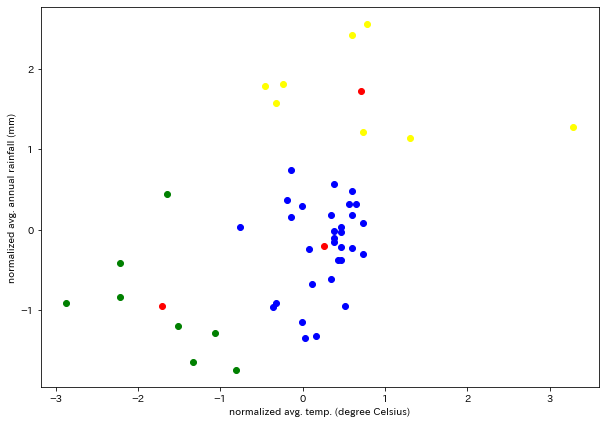

In [110]:
X = weather_df[['Temp', 'Rain']].values # データフレーム から配列に変換
X = (X-X.mean(axis=0))/X.std(axis=0) # 標準化
clusters, centers, cost=kmeans(X, 3)

# 可視化
plt.figure(figsize=(10,7))
plt.xlabel('normalized avg. temp. (degree Celsius)')
plt.ylabel('normalized avg. annual rainfall (mm)')
plt.scatter(X[clusters==0,0],X[clusters==0,1],c='blue')
plt.scatter(X[clusters==1,0],X[clusters==1,1],c='green')
plt.scatter(X[clusters==2,0],X[clusters==2,1],c='yellow')
plt.scatter(centers[:,0], centers[:,1], c='red'); # クラスタの中心点

The value of cost function should be $\simeq32$. The cluster centres should be `(0.2..., -0.1...)`, `(-1.7..., -0.9...)`, `(0.7..., 1.7...)`.

In [111]:
# コスト関数の値
print(cost)

# クラスタの中心点
print(centers)

32.39278477410994
[[ 0.25666107 -0.19969693]
 [-1.70770545 -0.94854049]
 [ 0.71314379  1.72236611]]


You can perform K-means method as follows by using `KMeans` class in scikit-learn module.


32.39278477410994
[[-1.70770545 -0.94854049]
 [ 0.25666107 -0.19969693]
 [ 0.71314379  1.72236611]]


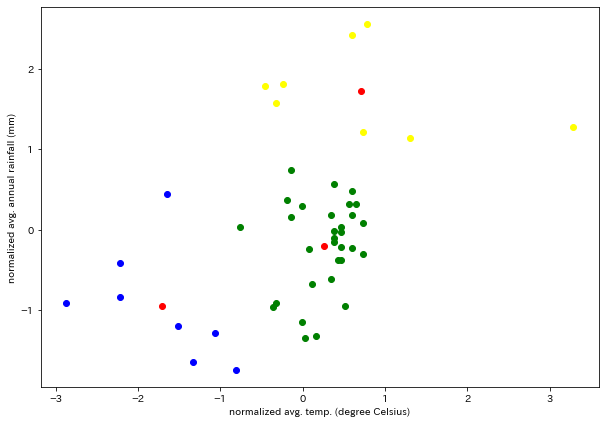

In [112]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3) 
model.fit(X) 
clusters=model.predict(X) 

plt.figure(figsize=(10,7))
plt.xlabel('normalized avg. temp. (degree Celsius)')
plt.ylabel('normalized avg. annual rainfall (mm)')
plt.scatter(X[clusters==0,0],X[clusters==0,1],c='blue')
plt.scatter(X[clusters==1,0],X[clusters==1,1],c='green')
plt.scatter(X[clusters==2,0],X[clusters==2,1],c='yellow')

plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], c='red'); # クラスタの中心点
print(model.inertia_) # コスト関数の値
print(model.cluster_centers_) # クラスタの中心点

### Q3 Elbow method
In elbow method, the optimum number of clusters is decided based on the change in the cost of clustering while the number of clusters is increased.

As the number of clusters is increased, the cost of clustering (sometimes) decreases significantly and then decreases slowly (this looks like 'elbow' in the graph of the number of clusters vs. cost). We use this tipping point as the optimum number of clusters.

Complete the following `elbow` function that uses the `kmeans` function in Q2 to return the list of the cost values of clustering as the number of clusters is increased from 1 to K. 


In [115]:
def elbow(X, K):
    ### Arguments：
    # X: Input matrix
    # K: the maximum number of clusters    
    
    costs=[]
    for i in range(1,K+1):
      clusters, centers, cost=kmeans(X, i)
      costs.append(cost)    
    return costs

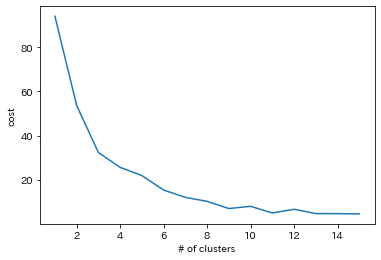

In [116]:
X = weather_df[['Temp', 'Rain']].values # データフレーム から配列に変換
X = (X-X.mean(axis=0))/X.std(axis=0) # 標準化
K = 15
costs = elbow(X, 15)
plt.xlabel("# of clusters")
plt.ylabel("cost")
plt.plot(range(1,K+1),costs);

### 参考
地図上でのクラスタの可視化

In [117]:
!pip install japanmap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 167 kB 5.2 MB/s 


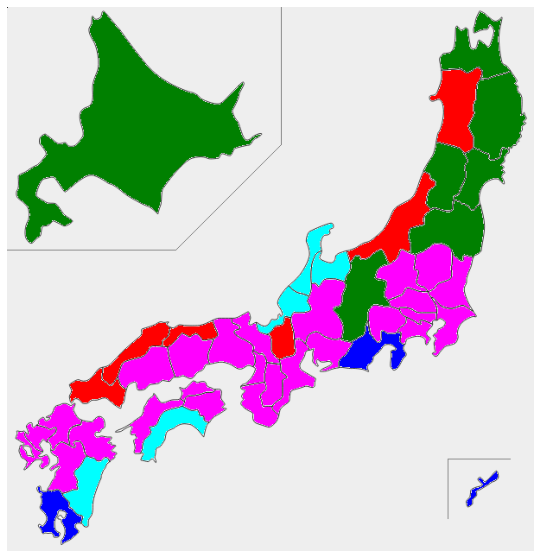

In [118]:
import japanmap as jm
colors = {0:"red", 1:"green", 2:"blue", 3:"cyan", 4:"magenta", 5:"yellow", 6:"black", 7:"white"}
k=5
plt.figure(figsize=(10, 10))
plt.imshow(jm.picture({p:c for p, c in zip(weather_df['Pref'].values, [colors[c] for c in kmeans(X, k)[0]])}))
plt.axis('off');

## Code Testing


In [119]:
## Run this cell first
!pip install prog_edu_assistant_tools
import re
import sys
import jinja2
from IPython.core import display
from google.colab import _message as google_message
from prog_edu_assistant_tools.magics import report, autotest, CaptureOutput
from prog_edu_assistant_tools.check import Check

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.3 MB/s 


## Q1

In [120]:
# Run this cell to check your solution.
# If you get an error 'Check not defined', make sure you have run all preceding
# cells once (Runtime -> Run before)
Check('q1')

## Q2

In [121]:
# Run this cell to check your solution.
# If you get an error 'Check not defined', make sure you have run all preceding
# cells once (Runtime -> Run before)
Check('q2')

## Q3

In [122]:
# Run this cell to check your solution.
# If you get an error 'Check not defined', make sure you have run all preceding
# cells once (Runtime -> Run before)
Check('q3')